## Data import, featurization, and tSNE plots

In [ ]:
import os
import re
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# Sampling functions (make sure they are implemented)
from div import *
from sampling import *
from comp import *

# Directory setup
root_dir = "D:/Postdoc-Work/Results/ML_Codes/Andrew-ML/naffinity"
output_csv_path = os.path.join(root_dir, "processed_affinity_data.csv")
npy_save_path = os.path.join(root_dir, 'processed_affinity_data_MACCS.npy')
tSNE_output_path = os.path.join(root_dir, 'tSNE_quota_samp_RR-80P.csv')

def clean_affinity_value(line, folder):
    val_str = ""
    try:
        if "(M):" not in line:
            return 1e1, 0, None
        val_str = line.split("(M):")[-1].strip()
        val_str = val_str.replace(" ", "").replace(",", ".").replace("–", "-").replace("x", "*").replace("\u200b", "")
        if val_str.lower() in ["na", "n/a", "none"]:
            return 1e1, 0, None
        if val_str.startswith(">") or val_str.startswith("<"):
            val_str = val_str[1:]
        match = re.search(r'[\d\.]+e[-+]?\d+|[\d\.]+', val_str, re.IGNORECASE)
        if not match:
            raise ValueError(f"No numeric match in '{val_str}'")
        val_str_clean = match.group(0)
        affinity = float(eval(val_str_clean))
        label = int(affinity < 1e-6)
        return affinity, label, None
    except Exception as e:
        return 1e1, 0, f"⚠️ Failed to parse in {folder}: eval('{val_str}') → {e}"

# Feature extraction
data = []
for folder in os.listdir(root_dir):
    folder_path = os.path.join(root_dir, folder)
    if not os.path.isdir(folder_path):
        continue
    desc_path = os.path.join(folder_path, "descriptors.txt")
    rdkit_path = os.path.join(folder_path, "rdkit.txt")
    receptor_path = os.path.join(folder_path, "receptor_descriptors.txt")
    affinity_path = os.path.join(folder_path, "features.txt")
    if not all(os.path.exists(p) for p in [desc_path, rdkit_path, affinity_path]):
        continue
    try:
        features = {}
        for file_path in [desc_path, rdkit_path, receptor_path]:
            if not os.path.exists(file_path):
                print(f"⚠️ Missing {os.path.basename(file_path)} in {folder} — filling with zeros")
                continue
            with open(file_path, 'r') as f:
                for line in f:
                    if ":" in line:
                        k, v = line.strip().split(":", 1)
                        try:
                            value = float(v.strip())
                            if np.isnan(value) or np.isinf(value):
                                raise ValueError("invalid")
                            features[k.strip()] = value
                        except:
                            features[k.strip()] = 0.0
        with open(affinity_path, 'r') as f:
            line = f.readline().strip()
            affinity, label, error = clean_affinity_value(line, folder)
            features['AffinityValue'] = affinity
            features['Label'] = label
        features['ComplexID'] = folder[:4]
        features['Folder'] = folder
        data.append(features)
    except Exception as e:
        print(f"Error processing {folder}: {e}")

# DataFrame and cleaning
df = pd.DataFrame(data)
df.fillna(0.0, inplace=True)
df.replace([np.inf, -np.inf], 0.0, inplace=True)

# Drop all-zero and highly correlated columns
df_features_only = df.drop(columns=["Label", "AffinityValue", "ComplexID", "Folder"], errors='ignore')
all_zero_cols = df_features_only.columns[(df_features_only == 0).all()]
df.drop(columns=all_zero_cols, inplace=True)

corr_matrix = df.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop_corr = [col for col in upper_tri.columns if any(upper_tri[col] > 0.85)]
df.drop(columns=to_drop_corr, inplace=True)

# Save cleaned data
df.to_csv(output_csv_path, index=False)
print(f"✅ DataFrame saved to: {output_csv_path}")

# Save only numerical feature matrix (excluding target and metadata)
feature_cols = df.drop(columns=["Label", "AffinityValue", "ComplexID", "Folder"], errors='ignore').columns
np.save(npy_save_path, df[feature_cols].values)

# Sampling
fingerprints = np.load(npy_save_path)
n_ary = 'JT'     # RR, JT, SM
percentage = 10

# Get the sampled indexes with each methods
medoid_samp = medoid_sampling(fingerprints, n_ary, percentage)
outlier_samp = outlier_sampling(fingerprints, n_ary, percentage)
extremes_samp = extremes_sampling(fingerprints, n_ary, percentage)
strat_samp = stratified_sampling(fingerprints, n_ary, percentage)
quota_samp = quota_sampling(fingerprints, n_ary, percentage)

# Scale fingerprints before t-SNE
scaler = StandardScaler()
fingerprints_scaled = scaler.fit_transform(fingerprints)

# Apply t-SNE
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(fingerprints_scaled)




C:\Users\mmj\AppData\Local\Temp\ipykernel_33828\374469515.py:97: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr().abs()


✅ DataFrame saved to: D:/Postdoc-Work/Results/ML_Codes/Andrew-ML/naffinity\processed_affinity_data.csv


c:\Users\mmj\AppData\Local\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\mmj\AppData\Local\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


## Split the dataset

In [ ]:
# Save t-SNE coordinates
tsne_df = pd.DataFrame(X_tsne, columns=['tSNE1', 'tSNE2'])
tsne_df['Split'] = 'Total'
tsne_df.loc[medoid_samp, 'Split'] = 'Medoid'
tsne_df.to_csv(tSNE_output_path, index=False)
print(f"✅ tSNE coordinates saved to: {tSNE_output_path}")

# Prepare train-test split
labels = tsne_df['Split']
train_indices = labels[labels == 'Total'].index
test_indices = labels[labels == 'Medoid'].index

X_train = fingerprints[train_indices]
X_test = fingerprints[test_indices]
y_train = df.loc[train_indices, 'Label'].astype(int).values
y_test = df.loc[test_indices, 'Label'].astype(int).values

print(f"✅ Final X_train shape: {X_train.shape}")
print(f"✅ Final X_test shape: {X_test.shape}")

✅ tSNE coordinates saved to: D:/Postdoc-Work/Results/ML_Codes/Andrew-ML/naffinity\tSNE_quota_samp_RR-80P.csv
✅ Final X_train shape: (129, 138)
✅ Final X_test shape: (1168, 138)


## Plot the molecular chemical space 

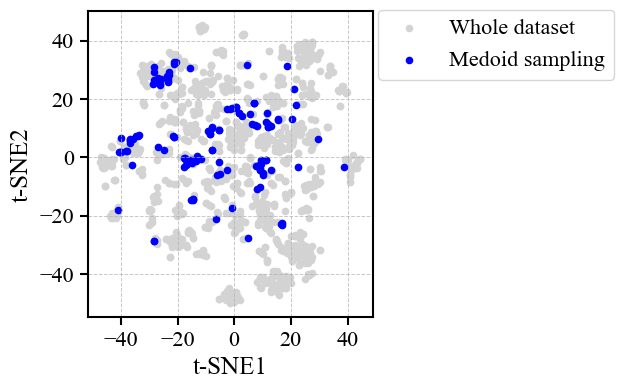

In [5]:
import matplotlib.pyplot as plt

# Set global font to Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

plt.figure(figsize=(6.3, 4))  # Increase figure size

# plt.subplot(244)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c='lightgray', s=20, label='Whole dataset')
plt.scatter(X_tsne[medoid_samp, 0], X_tsne[medoid_samp, 1], c='blue', s=20, label='Medoid sampling')

plt.xlabel('t-SNE1', fontsize=18)
plt.ylabel('t-SNE2', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)

# Increase axis lines thickness
ax = plt.gca()
ax.spines['top'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.tick_params(width=1.5, length=6)  # Increase tick size and width

# Legend outside
plt.legend(fontsize=16, loc='center left', bbox_to_anchor=(0.98, 0.89))

plt.tight_layout()

plt.savefig('Andrew_tSNE_JT-MFs-10P_Medoid.png', dpi = 1200)
plt.show()

## Training and Predictions

In [ ]:
xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', XGBClassifier(
        learning_rate=0.1,
        max_depth=3,
        n_estimators=1000,
        subsample=0.8,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    ))
])

xgb_pipeline.fit(X_train, y_train)
xgb_preds = xgb_pipeline.predict(X_test)

# Convert to Series before mapping
label_map = {0: "Weak Binders (≥1 μM)", 1: "Strong Binders (<1 μM)"}
y_test_named = pd.Series(y_test).map(label_map)
xgb_named = pd.Series(xgb_preds).map(label_map)

# Evaluation metrics
print("  Accuracy :", accuracy_score(y_test, xgb_preds))
print("  Precision:", precision_score(y_test, xgb_preds))
print("  Recall   :", recall_score(y_test, xgb_preds))
print("  F1 Score :", f1_score(y_test, xgb_preds))
print(classification_report(y_test_named, xgb_named, digits=4))
